In [1]:
!pip install datasets
!pip install pandas

!pip install scikit-learn
!pip install scikit-multilearn

!pip install transformers
!pip install accelerate

!pip install tqdm

In [2]:
from statistics import mean, stdev

import pandas as pd
import warnings
import numpy as np

from datasets import Dataset, load_from_disk
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
import torch



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments


from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, precision_score, recall_score

warnings.filterwarnings("ignore")


In [3]:
dataset = load_from_disk(str("./prepared-dataset"))

In [21]:
def conf_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test.to_numpy(), y_pred)
    mat = ConfusionMatrixDisplay(confusion_matrix=cm)
    return mat

def simple_models(dataset, X, y, model, vectorizer):
    skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    f1_scores = []
    res_mod = [] 
    precision = []
    recall = []
    matrices = []
    for train_index, test_index in tqdm(skf.split(X, y)):
        train = dataset.iloc[train_index]
        test = dataset.iloc[test_index]
        x_train = train["message"]
        y_train = train["is_toxic"]
        x_test = test["message"]
        y_test = test["is_toxic"]
        
        train_ = vectorizer.fit_transform(x_train)
        test_ = vectorizer.transform(x_test)
        
        my_model = models[model]
        my_model.fit(train_, y_train)

        print("Fold test")
        y_pred = np.array(my_model.predict(test_))
        print("Acc: ", accuracy_score(y_test, y_pred))
        print("F1 Score: ", f1_score(y_test, y_pred))

        scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        res_mod.append(my_model)
        matrices.append(conf_matrix(y_test, y_pred))

    

    print("Mean accuracy: ", mean(scores))
    print("Mean f1 score: ",mean(f1_scores))
    print("Mean precision: ",mean(precision))
    print("Mean recall: ",mean(recall))

    best_idx = np.argmax(np.array(f1_scores))
    matrices[best_idx].plot()
    return res_mod[best_idx]

In [23]:
def calc_metrics(prediction):
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        prediction.label_ids, np.argmax(prediction.predictions, axis=1), average="weighted"
    )
     
    acc = accuracy_score(prediction.label_ids, np.argmax(prediction.predictions, axis=1))
    return {"F1Score": f1, "AccuracyScore": acc,  "PrecisionScore": precision, "RecallScore": recall}    



def code_ro_bert_a(train, test, model, token_fun):
    test_ = test.map(token_fun, batched=True)
    train_ = train.map(token_fun, batched=True)
    
    model_ = RobertaForSequenceClassification.from_pretrained(model, num_labels=2)
    
    args = TrainingArguments(
        output_dir=f"./trained-{model}",
        learning_rate=2e-5,
        per_device_train_batch_size=5,
        per_device_eval_batch_size=5,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
    )
    
    mod_train = Trainer(
        model=model_,
        args=args,
        train_dataset=train_,
        eval_dataset=test_,
        compute_metrics=calc_metrics)
    
    mod_train.train()
    return mod_train
    
    


In [25]:
models = {
    "logistic_regression": LogisticRegression(solver="liblinear"),
    "random_forest": RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
}


def classifier(dataset, model):
    dataset = dataset.to_pandas()
    
    X = dataset["message"]
    y = dataset["is_toxic"]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)
    if model in ["logistic_regression", "random_forest"]:
        vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=150000)
        mod = simple_models(dataset, X, y, model, vectorizer)
    elif model in ["roberta-base", "microsoft/codebert-base"]:
        train_ = Dataset.from_pandas(pd.DataFrame({"text": x_train, "label": y_train}))
        test_ = Dataset.from_pandas(pd.DataFrame({"text": x_test, "label": y_test}))
        
        tokenizer = AutoTokenizer.from_pretrained(model)
        token_fun = lambda tokens: tokenizer(tokens["text"], truncation=True, padding="max_length")
    
        result_mod = code_ro_bert_a(train_, test_, model, token_fun)
        res = result_mod.evaluate()
        print(f"Accuracy: {res['eval_AccuracyScore']:.4f}")
        print(f"Precision: {res['eval_PrecisionScore']:.4f}")
        print(f"Recall: {res['eval_RecallScore']:.4f}")
        print(f"F1 Score: {res['eval_F1Score']:.4f}")
    else:
        vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

        model_lr = simple_models(dataset, x_train, y_train, "logistic_regression", vectorizer)
        y_pred_lr = np.array(model_lr.predict(vectorizer.transform(x_test)))
        del model_lr 
        
        model_rf = simple_models(dataset, x_train, y_train, "random_forest", vectorizer)
        y_pred_rf = np.array(model_rf.predict(vectorizer.transform(x_test)))
        del model_rf

        
        x_train, verify_x, y_train, verify_y = train_test_split(x_train, y_train, train_size=0.8, random_state=42, shuffle=True)
        
        
        tokenizer = AutoTokenizer.from_pretrained("roberta-base")
        token_fun = lambda tokens: tokenizer(tokens["text"], truncation=True, padding="max_length")
        
        train_ = Dataset.from_pandas(pd.DataFrame({"text": x_train, "label": y_train}))
        vefify_ = Dataset.from_pandas(pd.DataFrame({"text": verify_x, "label": verify_y}))
            
            
        model_roberta = code_ro_bert_a(train_, vefify_, "roberta-base", token_fun)
        test_ = Dataset.from_pandas(pd.DataFrame({"text": x_test, "label": y_test})).map(token_fun, batched=True)
        res_roberta = model_roberta.evaluate(test_)
        del model_roberta
        
        tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        token_fun = lambda tokens: tokenizer(tokens["text"], truncation=True, padding="max_length")
        
        model_codebert = code_ro_bert_a(train_, vefify_, "microsoft/codebert-base", token_fun)
        
        test_ = Dataset.from_pandas(pd.DataFrame({"text": x_test, "label": y_test})).map(token_fun, batched=True)
        
        res_codebert = model_codebert.evaluate(test_)
        del model_codebert

        
        print("\n LR validation\n")
        print("ACCURACY: ", accuracy_score(y_test, y_pred_lr))
        print("PRECISION: ", precision_score(y_test, y_pred_lr))
        print("RECALL: ", recall_score(y_test, y_pred_lr))
        print("F1 SCORE: ", f1_score(y_test, y_pred_lr))

        print("\nRF validation\n")
        print("ACCURACY: ", accuracy_score(y_test, y_pred_rf))
        print("PRECISION: ", precision_score(y_test, y_pred_rf))
        print("RECALL: ", recall_score(y_test, y_pred_rf))
        print("F1 SCORE: ", f1_score(y_test, y_pred_rf))

        print("\nROBERTA-BASE validation\n")
        print(f"Accuracy: {res_roberta['eval_AccuracyScore']:.4f}")
        print(f"Precision: {res_roberta['eval_PrecisionScore']:.4f}")
        print(f"Recall: {res_roberta['eval_RecallScore']:.4f}")
        print(f"F1 Score: {res_roberta['eval_F1Score']:.4f}")

        
        print("\nCODEBRT validation\n")
        print(f"Accuracy: {res_codebert['eval_AccuracyScore']:.4f}")
        print(f"Precision: {res_codebert['eval_PrecisionScore']:.4f}")
        print(f"Recall: {res_codebert['eval_RecallScore']:.4f}")
        print(f"F1 Score: {res_codebert['eval_F1Score']:.4f}")

        

        
        
 

2it [00:00,  7.50it/s]

Fold test
Acc:  0.8985623003194888
F1 Score:  0.6684073107049608
Fold test
Acc:  0.9033546325878594
F1 Score:  0.6889460154241646


4it [00:00,  7.50it/s]

Fold test
Acc:  0.8833865814696485
F1 Score:  0.5944444444444444
Fold test
Acc:  0.8801916932907349
F1 Score:  0.6073298429319371


6it [00:00,  7.56it/s]

Fold test
Acc:  0.8985623003194888
F1 Score:  0.6666666666666666
Fold test
Acc:  0.8913738019169329
F1 Score:  0.6421052631578947


8it [00:01,  7.62it/s]

Fold test
Acc:  0.889776357827476
F1 Score:  0.6329787234042553
Fold test
Acc:  0.9000799360511591
F1 Score:  0.6736292428198434


10it [00:01,  7.57it/s]

Fold test
Acc:  0.8976818545163869
F1 Score:  0.6631578947368421
Fold test
Acc:  0.8952837729816147
F1 Score:  0.6506666666666666
Mean accuracy:  0.893825323128079
Mean f1 score:  0.6488332070957675
Mean precision:  0.8965877156696933
Mean recall:  0.5089108741126848


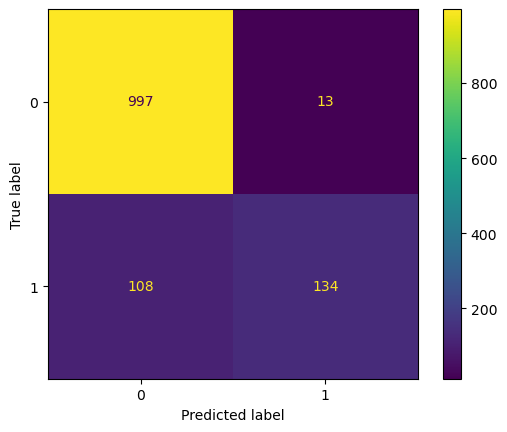

In [27]:
classifier(dataset, "logistic_regression")

2it [00:00,  9.78it/s]

Fold test
Acc:  0.906187624750499
F1 Score:  0.7006369426751592
Fold test
Acc:  0.8822355289421158
F1 Score:  0.6193548387096774


5it [00:00,  9.52it/s]

Fold test
Acc:  0.8772455089820359
F1 Score:  0.5773195876288659
Fold test
Acc:  0.8861138861138861
F1 Score:  0.6148648648648649
Fold test
Acc:  0.8841158841158842
F1 Score:  0.5886524822695035


8it [00:00,  9.69it/s]

Fold test
Acc:  0.8841158841158842
F1 Score:  0.6352201257861635
Fold test
Acc:  0.8911088911088911
F1 Score:  0.6148409893992933
Fold test
Acc:  0.8991008991008991
F1 Score:  0.6710097719869706


10it [00:01,  9.51it/s]


Fold test
Acc:  0.8911088911088911
F1 Score:  0.632996632996633
Fold test
Acc:  0.8931068931068931
F1 Score:  0.6421404682274248
Mean accuracy:  0.889443989144588
Mean f1 score:  0.6297036704544556
Mean precision:  0.8990184864863111
Mean recall:  0.4857457275113282


1it [00:00,  1.54it/s]

Fold test
Acc:  0.9191616766467066
F1 Score:  0.7743732590529248


2it [00:01,  1.56it/s]

Fold test
Acc:  0.9111776447105788
F1 Score:  0.7478753541076487


3it [00:01,  1.53it/s]

Fold test
Acc:  0.908183632734531
F1 Score:  0.7386363636363636


4it [00:02,  1.50it/s]

Fold test
Acc:  0.9300699300699301
F1 Score:  0.7976878612716763


5it [00:03,  1.48it/s]

Fold test
Acc:  0.9080919080919081
F1 Score:  0.7088607594936709


6it [00:04,  1.46it/s]

Fold test
Acc:  0.9140859140859141
F1 Score:  0.7584269662921348


7it [00:04,  1.51it/s]

Fold test
Acc:  0.9180819180819181
F1 Score:  0.7453416149068323


8it [00:05,  1.52it/s]

Fold test
Acc:  0.9180819180819181
F1 Score:  0.7588235294117647


9it [00:05,  1.55it/s]

Fold test
Acc:  0.9200799200799201
F1 Score:  0.7633136094674556


10it [00:06,  1.53it/s]

Fold test
Acc:  0.913086913086913
F1 Score:  0.7433628318584071
Mean accuracy:  0.9160101375670238
Mean f1 score:  0.7536702149498878
Mean precision:  0.8753624839658359
Mean recall:  0.6628376860643677


Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/8010 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.584700
20,0.645600
30,0.516800
40,0.549700
50,0.277800
60,0.778000
70,0.489100
80,0.338200
90,0.784500
100,0.812500


Map:   0%|          | 0/2504 [00:00<?, ? examples/s]

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/8010 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.485900
20,0.669000
30,0.492000
40,0.491800
50,0.278500
60,0.551700
70,0.448600
80,0.312600
90,0.523800
100,0.587100


Map:   0%|          | 0/2504 [00:00<?, ? examples/s]


 LR validation

ACCURACY:  0.9013578274760383
PRECISION:  0.9390681003584229
RECALL:  0.532520325203252
F1 SCORE:  0.6796368352788587

RF validation

ACCURACY:  0.9688498402555911
PRECISION:  0.9662162162162162
RECALL:  0.8719512195121951
F1 SCORE:  0.9166666666666666

ROBERTA-BASE validation

Accuracy: 0.9221
Precision: 0.9198
Recall: 0.9221
F1 Score: 0.9192

CODEBRT validation

Accuracy: 0.9213
Precision: 0.9195
Recall: 0.9213
F1 Score: 0.9201


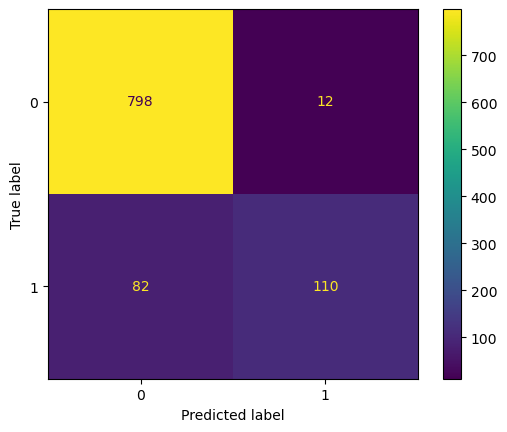

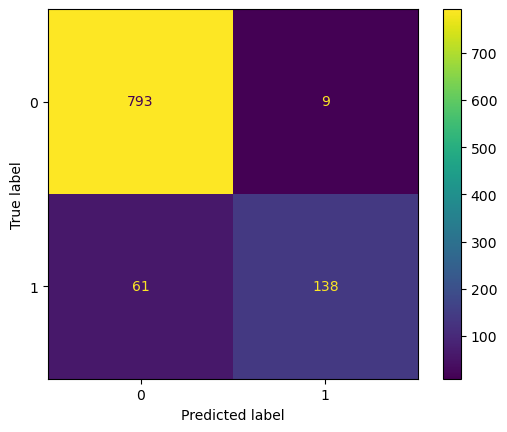

In [29]:
classifier(dataset, "")

1it [00:00,  1.10it/s]

Fold test
Acc:  0.9033546325878594
F1 Score:  0.7055961070559611


2it [00:01,  1.10it/s]

Fold test
Acc:  0.90814696485623
F1 Score:  0.7268408551068883


3it [00:02,  1.12it/s]

Fold test
Acc:  0.9073482428115016
F1 Score:  0.7156862745098039


4it [00:03,  1.13it/s]

Fold test
Acc:  0.9057507987220448
F1 Score:  0.7230046948356808


5it [00:04,  1.12it/s]

Fold test
Acc:  0.9145367412140575
F1 Score:  0.7482352941176471


6it [00:05,  1.11it/s]

Fold test
Acc:  0.9017571884984026
F1 Score:  0.7105882352941176


7it [00:06,  1.11it/s]

Fold test
Acc:  0.9017571884984026
F1 Score:  0.7064439140811456


8it [00:07,  1.10it/s]

Fold test
Acc:  0.9128697042366107
F1 Score:  0.7470997679814385


9it [00:08,  1.12it/s]

Fold test
Acc:  0.9280575539568345
F1 Score:  0.7926267281105991


10it [00:08,  1.12it/s]

Fold test
Acc:  0.9160671462829736
F1 Score:  0.7575057736720554
Mean accuracy:  0.9099646161664917
Mean f1 score:  0.7333627644765337
Mean precision:  0.8552085423753221
Mean recall:  0.6425877027536778


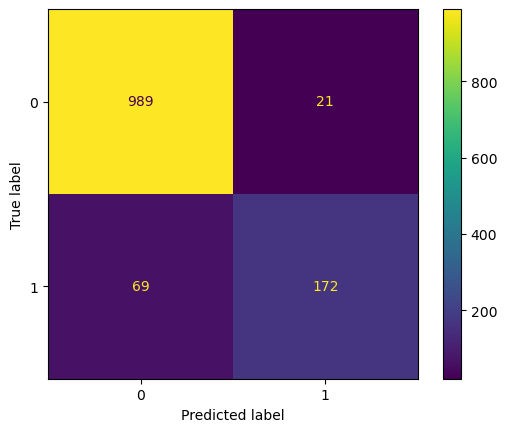

In [30]:
classifier(dataset, "random_forest")

In [31]:
classifier(dataset, "roberta-base")

Map:   0%|          | 0/2504 [00:00<?, ? examples/s]

Map:   0%|          | 0/10013 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.610700
20,0.514900
30,0.583400
40,0.394000
50,0.528700
60,0.384600
70,0.716700
80,0.294000
90,0.495000
100,0.305600


Accuracy: 0.9253
Precision: 0.9233
Recall: 0.9253
F1 Score: 0.9237


In [35]:
classifier(dataset, "microsoft/codebert-base")

Map:   0%|          | 0/2504 [00:00<?, ? examples/s]

Map:   0%|          | 0/10013 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.555700
20,0.542900
30,0.598000
40,0.397000
50,0.464300
60,0.344300
70,0.698300
80,0.569700
90,0.445200
100,0.256900


Accuracy: 0.9201
Precision: 0.9183
Recall: 0.9201
F1 Score: 0.9189
